In [ ]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

2.15.0
2.15.0


In [ ]:
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from keras.utils import pad_sequences
from keras.layers import Masking
from tensorflow.python.client import device_lib
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from pickle import dump
import pandas as pd

In [ ]:
print(device_lib.list_local_devices() )

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17075325548513564366
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 21991653376
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1380661487508038636
physical_device_desc: "device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [ ]:
df = pd.read_csv("./dfcsv3.csv")
df_test = pd.read_csv("./dfcsv_anomaly.csv")

In [ ]:
MASK_VALUE = 100000.0

arr = df.to_numpy()
arr_test = df_test.to_numpy()
print(df)
print(arr[3])

      num         time        gX        gY        gZ     aX     aY     aZ  \
0     0.0          0.0  0.000314  0.003299 -0.001065 -0.005  0.009  0.002   
1     0.0     100354.0  0.001658 -0.000960  0.000279  0.002  0.010  0.042   
2     0.0     197939.0 -0.000209 -0.002548 -0.000524 -0.006  0.005  0.016   
3     0.0     344200.0  0.001658  0.005166 -0.001326 -0.003 -0.001  0.001   
4     0.0     441704.0  0.004573  0.001449  0.001344 -0.000  0.002  0.001   
...   ...          ...       ...       ...       ...    ...    ...    ...   
6025  0.0  598751628.0 -0.001815  0.004904  0.000803  0.019 -0.001 -0.159   
6026  0.0  598849126.0  0.001379 -0.002286  0.000541  0.034 -0.020 -0.165   
6027  0.0  598946642.0 -0.003142 -0.000698  0.000000  0.010 -0.009 -0.185   
6028  0.0  599044136.0  0.001658 -0.000960 -0.003456  0.018 -0.024 -0.162   
6029  0.0  599141640.0  0.000314 -0.001484  0.001082  0.023 -0.000 -0.171   

         pitch      roll  
0     1.031590 -0.496932  
1     0.233488  0.046

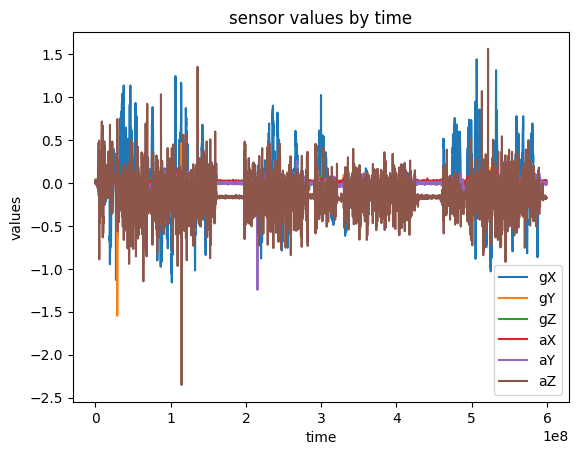

In [ ]:
fig2 = plt.figure()
ax = fig2.add_subplot(1,1,1)
ax.plot(df['time'],df['gX'],label='gX')
ax.plot(df['time'],df['gY'],label='gY')
ax.plot(df['time'],df['gZ'],label='gZ')
ax.plot(df['time'],df['aX'],label='aX')
ax.plot(df['time'],df['aY'],label='aY')
ax.plot(df['time'],df['aZ'],label='aZ')
ax.set_xlabel('time')
ax.set_ylabel('values')
ax.set_title('sensor values by time')
ax.legend()
fig2.show()

In [ ]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(arr[:,2:])
test_scaled = scaler.transform(arr_test[:,2:])
dump(scaler,open('./minmax_scaler.pkl','wb'))

In [ ]:
# 시퀀스 데이터 생성 함수
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length]
        sequences.append(sequence)
    return np.array(sequences)

sequences = create_sequences(train_scaled, 1)
sequences_test = create_sequences(test_scaled,1)

In [ ]:
def create_lstm_autoencoder(sequence_length,num_features):
    inputs = Input(shape=(sequence_length,num_features))

    encoded = LSTM(32,activation='relu',return_sequences=True)(inputs)
    encoded = LSTM(4,activation='relu',return_sequences=False)(encoded)
    encoded = RepeatVector(sequence_length)(encoded)

    decoded = LSTM(4,activation='relu',return_sequences=True)(encoded)
    decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(num_features))(decoded)

    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
    return autoencoder

autoencoder = create_lstm_autoencoder(sequences.shape[1],sequences.shape[2])
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)



In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 8)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 32)             5248      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 592       
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 4)              0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 32)             4736      
                                                             

In [ ]:
history=autoencoder.fit(sequences, sequences, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping]).history

Epoch 1/100
170/170 [==============================] - 9s 14ms/step - loss: 0.2212 - accuracy: 0.1552 - val_loss: 0.0094 - val_accuracy: 0.8839
Epoch 2/100
170/170 [==============================] - 2s 10ms/step - loss: 0.0047 - accuracy: 0.8704 - val_loss: 0.0047 - val_accuracy: 0.8839
Epoch 3/100
170/170 [==============================] - 2s 11ms/step - loss: 0.0043 - accuracy: 0.8704 - val_loss: 0.0046 - val_accuracy: 0.8839
Epoch 4/100
170/170 [==============================] - 2s 10ms/step - loss: 0.0041 - accuracy: 0.8704 - val_loss: 0.0043 - val_accuracy: 0.8839
Epoch 5/100
170/170 [==============================] - 2s 11ms/step - loss: 0.0038 - accuracy: 0.8704 - val_loss: 0.0040 - val_accuracy: 0.8839
Epoch 6/100
170/170 [==============================] - 2s 12ms/step - loss: 0.0036 - accuracy: 0.8704 - val_loss: 0.0038 - val_accuracy: 0.8839
Epoch 7/100
170/170 [==============================] - 2s 12ms/step - loss: 0.0035 - accuracy: 0.8738 - val_loss: 0.0037 - val_accuracy:

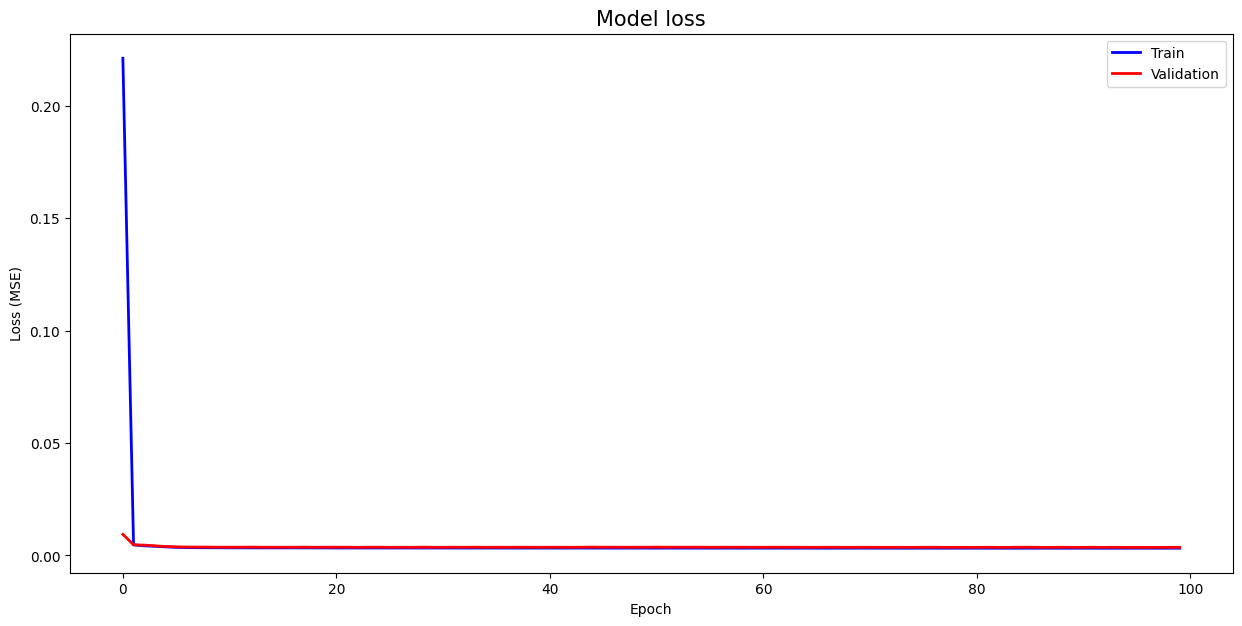

In [ ]:
fig,ax = plt.subplots(figsize=(15,7))
ax.plot(history['loss'],'b',label='Train',linewidth=2)
ax.plot(history['val_loss'],'r',label='Validation',linewidth=2)
ax.set_title('Model loss',fontsize=15)
ax.set_ylabel('Loss (MSE)')
ax.set_xlabel('Epoch')
ax.legend()
plt.show()

In [ ]:
pred_train = autoencoder.predict(sequences)
print(pred_train.shape)


189/189 [==============================] - 1s 3ms/step
(6029, 1, 8)


In [ ]:
def calculate_error(original,reconstructed):
  return np.mean(np.abs(original-reconstructed),axis=(1))

reconstructed_error = calculate_error(sequences,pred_train)

print(reconstructed_error[0])
print(reconstructed_error[1])

[0.04905434 0.00329843 0.03389101 0.08741426 0.04918413 0.01489249
 0.11734904 0.2734168 ]
[0.01944125 0.00410841 0.01555691 0.04398159 0.00453448 0.04760485
 0.02270327 0.04038349]


In [ ]:
reconstructed_error.shape

(6029, 8)

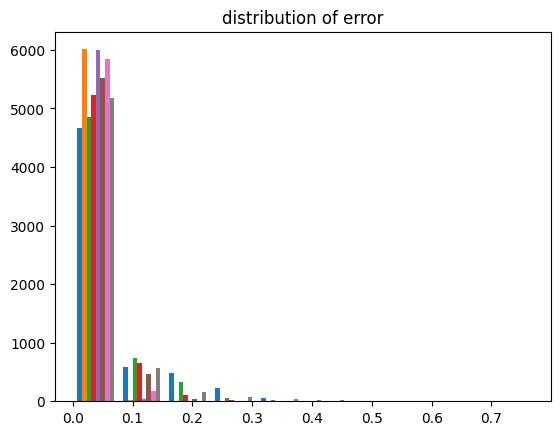

In [ ]:
plt.hist(reconstructed_error)
plt.title('distribution of error')
plt.show()

In [ ]:
pred_test = autoencoder.predict(sequences_test)
#print(pred_test)
pred_test.shape

26/26 [==============================] - 0s 2ms/step


(812, 1, 8)

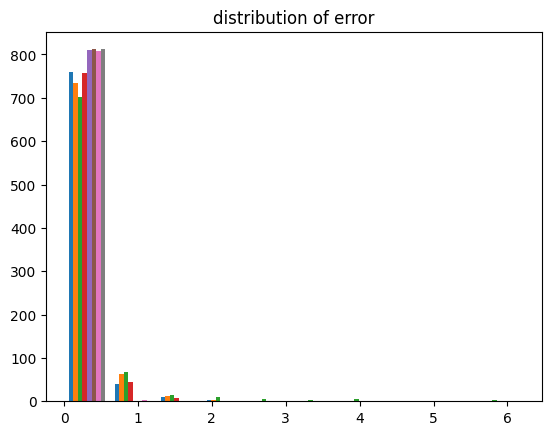

In [ ]:
reconstructed_error_test = calculate_error(sequences_test,pred_test)
plt.hist(reconstructed_error_test)
plt.title('distribution of error')
plt.show()

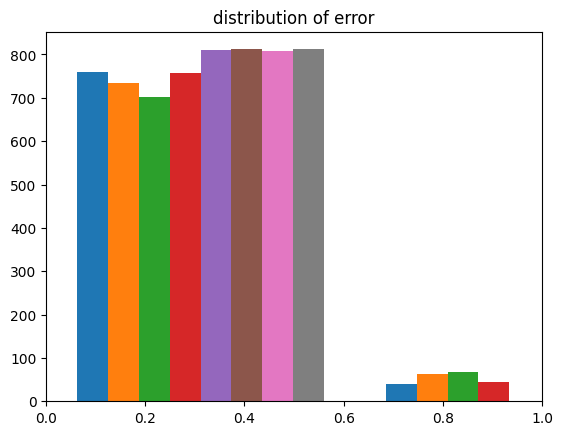

In [ ]:
reconstructed_error_test = calculate_error(sequences_test,pred_test)
plt.hist(reconstructed_error_test)
plt.title('distribution of error')
plt.xlim([0, 1])
plt.show()

In [ ]:
autoencoder.save('model.h5')

scaler = load(open('./minmax_scaler.pkl','rb'))

min_ = scaler.min_
scale_ = scaler.scale_

print("min_: ", min_)
print("scale_: ", scale_)

In [ ]:
from tensorflow import keras
autoencoder.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def representative_dataset_gen():
    for i in range(500):
      input = sequences_test[i:i+1].astype(np.float32)
      yield [input]

run_model = tf.function(lambda x: autoencoder(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = 1
INPUT_SIZE = 8
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], tf.float32))

# model directory.
MODEL_DIR = "model"
autoencoder.save(MODEL_DIR, save_format="tf",signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.representative_dataset = representative_dataset_gen
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.inference_input_type = tf.int8
#converter.inference_output_type = tf.int8
tflite_model = converter.convert()
with open("model.tflite","wb") as f:
    f.write(tflite_model)

48552